# Loading and Preprocessing Data

In this notebook you will learn how to use TensorFlow's Data API to load and preprocess data efficiently, then you will learn about the efficient `TFRecord` binary format for storing your data.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
from pprint import pprint

In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
tensorflow 2.0.0-dev20190227
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [5]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

## Code examples

You can browse through the code examples or jump directly to the exercises.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
dataset

<TensorSliceDataset shapes: (), types: tf.int64>

In [8]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [9]:
dataset = dataset.repeat(3).batch(7)

In [10]:
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [11]:
dataset = dataset.interleave(
    lambda v: tf.data.Dataset.from_tensor_slices(v),
    cycle_length=3,
    block_length=2)

In [12]:
for item in dataset:
    print(item.numpy(), end=" ")

0 1 7 8 4 5 2 3 9 0 6 7 4 5 1 2 8 9 6 3 0 1 2 8 9 3 4 5 6 7 

In [13]:
X = np.array([[2, 3], [4, 5], [6, 7]])
y = np.array(["cat", "dog", "fox"])
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset

<TensorSliceDataset shapes: ((2,), ()), types: (tf.int64, tf.string)>

In [14]:
for item_x, item_y in dataset:
    print(item_x.numpy(), item_y.numpy())

[2 3] b'cat'
[4 5] b'dog'
[6 7] b'fox'


In [15]:
dataset = tf.data.Dataset.from_tensor_slices({"features": X, "label": y})
dataset

<TensorSliceDataset shapes: {features: (2,), label: ()}, types: {features: tf.int64, label: tf.string}>

In [16]:
for item in dataset:
    print(item["features"].numpy(), item["label"].numpy())

[2 3] b'cat'
[4 5] b'dog'
[6 7] b'fox'


## Split the California dataset to multiple CSV files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [17]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

For very large datasets that do not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the scaled housing dataset and saving it to 20 CSV files:

In [18]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filenames = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filenames.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filenames

In [19]:
train_data = np.c_[X_train_scaled, y_train]
valid_data = np.c_[X_valid_scaled, y_valid]
test_data = np.c_[X_test_scaled, y_test]
header_cols = ["Scaled" + name for name in housing.feature_names] + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filenames = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filenames = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filenames = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [20]:
with open(train_filenames[0]) as f:
    for i in range(3):
        print(f.readline(), end="")

ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue
-0.1939788334343112,-1.0778131900560315,-0.9433854492905827,0.01485313784785944,0.020733351231179677,-0.5729162417603235,0.9292604730832086,-1.4221552292446311,1.442
0.7519831792363448,-1.8688949973875395,0.4054779316683507,-0.2332768194594582,1.861464900604635,0.20516532460775205,-0.9165473773933427,1.096669692658571,1.687


![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – Data API

### 1.1)
Use `tf.data.Dataset.list_files()` to create a dataset that will simply list the training filenames. Iterate through its items and print them.

In [21]:
dataset_files = tf.data.Dataset.list_files(train_filenames)

In [22]:
pprint(list(dataset_files))

[<tf.Tensor: id=186, shape=(), dtype=string, numpy=b'datasets/housing/my_train_01.csv'>,
 <tf.Tensor: id=187, shape=(), dtype=string, numpy=b'datasets/housing/my_train_17.csv'>,
 <tf.Tensor: id=188, shape=(), dtype=string, numpy=b'datasets/housing/my_train_16.csv'>,
 <tf.Tensor: id=189, shape=(), dtype=string, numpy=b'datasets/housing/my_train_07.csv'>,
 <tf.Tensor: id=190, shape=(), dtype=string, numpy=b'datasets/housing/my_train_04.csv'>,
 <tf.Tensor: id=191, shape=(), dtype=string, numpy=b'datasets/housing/my_train_00.csv'>,
 <tf.Tensor: id=192, shape=(), dtype=string, numpy=b'datasets/housing/my_train_14.csv'>,
 <tf.Tensor: id=193, shape=(), dtype=string, numpy=b'datasets/housing/my_train_10.csv'>,
 <tf.Tensor: id=194, shape=(), dtype=string, numpy=b'datasets/housing/my_train_11.csv'>,
 <tf.Tensor: id=195, shape=(), dtype=string, numpy=b'datasets/housing/my_train_05.csv'>,
 <tf.Tensor: id=196, shape=(), dtype=string, numpy=b'datasets/housing/my_train_18.csv'>,
 <tf.Tensor: id=197, 

### 1.2)
Use the filename dataset's `interleave()` method to create a dataset that will read from these CSV files, interleaving their lines. The first argument needs to be a function (e.g., a `lambda`) that creates a `tf.data.TextLineDataset` based on a filename, and you must also set `cycle_length=5` so that the reader interleaves data from 5 files at a time. Print the first 15 elements from this dataset to see that you do indeed get interleaved lines from multiple CSV files (you should get the first line from 5 files, then the second line from these same files, then the third lines). **Tip**: To get only the first 15 elements, you can call the dataset's `take()` method.

In [23]:
? dataset.interleave

In [24]:
n_repetitions = 5

In [25]:
dataset_files = dataset_files.interleave(lambda dataset_file: tf.data.TextLineDataset(dataset_file), 
                                         cycle_length=n_repetitions)

In [26]:
pprint(list(dataset_files.take(15)))

[<tf.Tensor: id=262, shape=(), dtype=string, numpy=b'ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue'>,
 <tf.Tensor: id=263, shape=(), dtype=string, numpy=b'ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue'>,
 <tf.Tensor: id=264, shape=(), dtype=string, numpy=b'ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue'>,
 <tf.Tensor: id=265, shape=(), dtype=string, numpy=b'ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue'>,
 <tf.Tensor: id=266, shape=(), dtype=string, numpy=b'ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue'>,
 <tf.Tensor: id=267, shap

### 1.3)
We do not care about the header lines, so let's skip them. You can use the `skip()` method for this. Print the first five elements of your final dataset to make sure it does not print any header lines. **Tip**: make sure to call `skip()` for each `TextLineDataset`, not for the interleave dataset.

In [27]:
dataset_files = dataset_files.skip(n_repetitions)

In [28]:
pprint(list(dataset_files.take(15)))

[<tf.Tensor: id=315, shape=(), dtype=string, numpy=b'-0.10698238234932358,1.2163240512053415,-0.36522430755132806,-0.22908029443843958,-0.882749164326441,0.10033860694954831,-0.7525796749398415,0.7168468869747529,1.625'>,
 <tf.Tensor: id=316, shape=(), dtype=string, numpy=b'-0.28605575156038454,0.662566786073286,-0.3692986080768526,-0.41074201720561043,-0.8818365557248676,0.11285159127079294,0.4795204892107495,-1.0573254290483325,2.526'>,
 <tf.Tensor: id=317, shape=(), dtype=string, numpy=b'0.15159767725728873,1.849189497070548,0.09624145072689123,-0.22151619913377374,-0.6682861429567027,-0.23549309239259542,-0.8978082113986573,0.6368841910413197,3.215'>,
 <tf.Tensor: id=318, shape=(), dtype=string, numpy=b'-0.45570144997355416,-0.5240559249239759,-0.18509612395969857,0.0025173270500037444,-0.7385570052778511,-0.2028592442325915,1.4586419124330796,-0.5075818945059632,1.069'>,
 <tf.Tensor: id=319, shape=(), dtype=string, numpy=b'0.1985265274512379,1.2954322319384923,-0.13117620706149458

### 1.4)
We need to parse these CSV lines. First, experiment with the `tf.io.decode_csv()` function using the example below (e.g., look at the types, try changing or removing some field values, etc.).
* You need to pass it the line to parse, and set the `record_defaults` argument. This must be an array containing the default value for each field, in case it is missing. This also tells TensorFlow the number of fields to expect, and the type of each field. If you do not want a default value for a given field, you must use an empty tensor of the appropriate type (e.g., `tf.constant([])` for a `float32` field, or `tf.constant([], dtype=tf.int64` for an `int64` field).

In [29]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: id=366, shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: id=367, shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: id=368, shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: id=369, shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: id=370, shape=(), dtype=float32, numpy=5.0>]

### 1.5)
Now you are ready to create a function to parse a CSV line:
* Create a `parse_csv_line()` function that takes a single line as argument.
* Call `tf.io.decode_csv()` to parse that line.
* Call `tf.stack()` to create a single tensor containing all the input features (i.e., all fields except the last one).
* Reshape the labels field (i.e., the last field) to give it a shape of `[1]` instead of `[]` (i.e., it must not be a scalar). You can use `tf.reshape(label_field, [1])`, or call `tf.stack([label_field])`, or use `label_field[tf.newaxis]`.
* Return a tuple with both tensors (input features and labels).
* Try calling it on a single line from one of the CSV files.

In [30]:
def parse_csv_line(line, n_features=9):
    """
    ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue
    """
    
    record_defaults = [tf.constant(np.nan) for _ in range(n_features)]
    parsed_fields = tf.io.decode_csv(line, record_defaults)
    
    x = tf.stack(parsed_fields[:-1])
    y = tf.stack(parsed_fields[-1:])
    
    return x, y

In [31]:
print(np.nan is np.nan)
print(np.nan == np.nan)

True
False


In [32]:
x, y = parse_csv_line('1,2,3,4,5,6,7,8,9')

tf.debugging.assert_equal(x, tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6., 7., 8.]))
tf.debugging.assert_equal(y, tf.constant([9.]))

In [33]:
len("ScaledMedInc,ScaledHouseAge,ScaledAveRooms,ScaledAveBedrms,ScaledPopulation,ScaledAveOccup,ScaledLatitude,ScaledLongitude,MedianHouseValue".split(','))

9

In [34]:
x, y = parse_csv_line(b'-0.739840972632228,-0.3658395634576743,-0.784679995482575,0.07414513752253027,0.7544706668961565,0.407700592469922,-0.686992593958441,0.6019005115704453,2.0')

tf.debugging.assert_equal(x, tf.constant([
    -0.739841,
    -0.36583957,
    -0.78468,
     0.07414514,
     0.75447065,
     0.4077006,
    -0.6869926,
     0.6019005
]))

tf.debugging.assert_equal(y, tf.constant([2.]))

### 1.6)
Now create a `csv_reader_dataset()` function that takes a list of CSV filenames and returns a dataset that will provide batches of parsed and shuffled data from these files, including the features and labels, repeating the whole data once per epoch.

**Tips**:
* Copy your code from above to get a dataset that returns interleaved lines from the given CSV files. Your function will need an argument for the `filenames`, and another for the number of files read in parallel at any given time (e.g., `n_reader`).
* The training algorithm will need to go through the dataset many times, so you should call `repeat()` on the filenames dataset. You do not need to specify a number of repetitions, as we will tell Keras the number of iterations to run later on.
* Gradient descent works best when the data is IID (independent and identically distributed), so you should call the `shuffle()` method. It will require the shuffling buffer size, which you can add as an argument to your function (e.g., `shuffle_buffer_size`).
* Use the `map()` method to apply the `parse_csv_line()` function to each CSV line. You can set the `num_parallel_calls` argument to the number of threads that will parse lines in parallel. This should probably be an argument of your function (e.g., `n_parse_threads`).
* Use the `batch()` method to bundle records into batches. You will need to specify the batch size. This should probably be an argument of your function (e.g., `batch_size`).
* Call `prefetch(1)` on your final dataset to ensure that the next batch is loaded and parsed while the rest of your computations take place in parallel (to avoid blocking for I/O).
* Return the resulting dataset.
* Give every argument a reasonable default value (except for the filenames).
* Test your function by calling it with a small batch size and printing the first couple of batches.
* For higher performance, you can replace `dataset.map(...).batch(...)` with `dataset.apply(map_and_batch(...))`, where `map_and_batch()` is an experimental function located in `tf.data.experimental`. It will be deprecated in future versions of TensorFlow when such pipeline optimizations become automatic.

In [35]:
def csv_reader_dataset(filenames, n_parse_threads=5, batch_size=32,
                       shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()  # let make infinite dataset
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)  # for performance

In [36]:
train_set = csv_reader_dataset(train_filenames, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print(f"X = {X_batch}\ny = {y_batch}\n\n")

X = [[-0.57281405 -0.5240559  -0.24298318  0.15274556 -0.4510853   0.11923176
  -0.82753634  0.61189586]
 [-0.18879361  1.5327568  -0.01413399 -0.24966547 -0.65733486 -0.42945862
   1.3696309  -0.9323837 ]
 [ 0.9390177   0.2670259   0.46980163 -0.2508443  -0.3132814   0.31472617
  -1.3334938   1.3365577 ]]
y = [[2.75 ]
 [1.479]
 [2.088]]


X = [[-0.7757185  -0.04940684 -0.7331179  -0.16466767 -0.8453322   1.1710402
  -0.77600366  0.67186785]
 [ 1.1180911   0.2670259   0.37279218 -0.21405643 -0.75133353 -0.03526263
   1.0791738  -1.2522345 ]
 [-0.10289706 -1.1569214  -0.22683562 -0.40810654 -0.9128652  -0.09459835
   1.411794   -0.8874047 ]]
y = [[0.964]
 [2.479]
 [1.161]]




### 1.7)
Build a training set, a validation set and a test set using your `csv_reader_dataset()` function.

In [37]:
train_dataset = csv_reader_dataset(train_filenames)

In [38]:
test_dataset = csv_reader_dataset(test_filenames)

In [39]:
valid_dataset = csv_reader_dataset(valid_filenames)

In [40]:
train_dataset.output_shapes[0][1:]

TensorShape([8])

### 1.8)
Build and compile a Keras model for this regression task, and use your datasets to train it, evaluate it and make predictions for the test set.

**Tips**
* Instead of passing `X_train_scaled, y_train` to the `fit()` method, pass the training dataset and specify the `steps_per_epoch` argument. This should be set to the number of instances in the training set divided by the batch size.
* Similarly, pass the validation dataset instead of `(X_valid_scaled, y_valid)` and `y_valid`, and set the `validation_steps`.
* For the `evaluate()` and `predict()` methods, you need to pass the test dataset, and specify the `steps` argument.
* The `predict()` method ignores the labels in the test dataset, but if you want to be extra sure that it does not cheat, you can create a new dataset by stripping away the labels from the test set (e.g., `test_set.map(lambda X, y: X)`).

In [41]:
def build_model():
    return keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=train_dataset.output_shapes[0][1:]),
        keras.layers.Dense(1),
    ])

In [42]:
model = build_model()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.input.shape

TensorShape([None, 8])

In [45]:
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
%time history = model.fit(train_dataset, epochs=100, steps_per_epoch=64, validation_steps=32, validation_data=valid_dataset, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(test_dataset, steps=1024)

Epoch 1/100
64/64 [==============================] - 1s 11ms/step - loss: 3.3688 - accuracy: 0.0015 - val_loss: 2.2570 - val_accuracy: 0.0020
Epoch 2/100
64/64 [==============================] - 0s 3ms/step - loss: 1.9877 - accuracy: 0.0039 - val_loss: 1.4730 - val_accuracy: 0.0039
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4436 - accuracy: 0.0020 - val_loss: 1.1308 - val_accuracy: 0.0039
Epoch 4/100
64/64 [==============================] - 0s 3ms/step - loss: 1.1178 - accuracy: 0.0024 - val_loss: 0.9690 - val_accuracy: 0.0039
Epoch 5/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4110 - accuracy: 0.0029 - val_loss: 0.8915 - val_accuracy: 0.0039
Epoch 6/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0022 - accuracy: 0.0024 - val_loss: 0.8148 - val_accuracy: 0.0039
Epoch 7/100
64/64 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.0039 - val_loss: 0.7732 - val_accuracy: 0.0039
Epoch 8/100


64/64 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.0024 - val_loss: 0.4842 - val_accuracy: 0.0039
Epoch 59/100
64/64 [==============================] - 0s 3ms/step - loss: 0.5236 - accuracy: 0.0024 - val_loss: 0.4821 - val_accuracy: 0.0039
Epoch 60/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4951 - accuracy: 0.0039 - val_loss: 0.4800 - val_accuracy: 0.0039
Epoch 61/100
64/64 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.0039 - val_loss: 0.4784 - val_accuracy: 0.0039
Epoch 62/100
64/64 [==============================] - 0s 3ms/step - loss: 0.5276 - accuracy: 0.0029 - val_loss: 0.4771 - val_accuracy: 0.0039
Epoch 63/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.0029 - val_loss: 0.4736 - val_accuracy: 0.0039
Epoch 64/100
64/64 [==============================] - 0s 3ms/step - loss: 0.4440 - accuracy: 0.0029 - val_loss: 0.4713 - val_accuracy: 0.0039
Epoch 65/100
64/64 

[0.4287934530293569, 0.002105713]

In [46]:
model.predict(X_test_scaled)

array([[0.36287138],
       [1.636884  ],
       [3.065917  ],
       ...,
       [1.3724762 ],
       [2.4283142 ],
       [3.7680511 ]], dtype=float32)

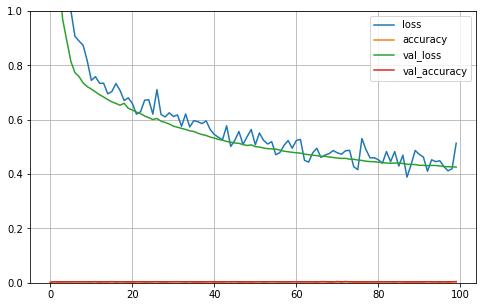

In [47]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 1 – Solution

### 1.1)
Use `tf.data.Dataset.list_files()` to create a dataset that will simply list the training filenames. Iterate through its items and print them.

In [ ]:
filename_dataset = tf.data.Dataset.list_files(train_filenames)

In [ ]:
for filename in filename_dataset:
    print(filename)

### 1.2)
Use the filename dataset's `interleave()` method to create a dataset that will read from these CSV files, interleaving their lines. The first argument needs to be a function (e.g., a `lambda`) that creates a `tf.data.TextLineDataset` based on a filename, and you must also set `cycle_length=5` so that the reader interleaves data from 5 files at a time. Print the first 15 elements from this dataset to see that you do indeed get interleaved lines from multiple CSV files (you should get the first line from 5 files, then the second line from these same files, then the third lines). **Tip**: To get only the first 15 elements, you can call the dataset's `take()` method.

In [ ]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers)

In [ ]:
for line in dataset.take(15):
    print(line.numpy())

### 1.3)
We do not care about the header lines, so let's skip them. You can use the `skip()` method for this. Print the first five elements of your final dataset to make sure it does not print any header lines. **Tip**: make sure to call `skip()` for each `TextLineDataset`, not for the interleave dataset.

In [ ]:
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename).skip(1),
    cycle_length=n_readers)

In [ ]:
for line in dataset.take(5):
    print(line.numpy())

### 1.4)
We need to parse these CSV lines. First, experiment with the `tf.io.decode_csv()` function using the example below (e.g., look at the types, try removing some field values, etc.).

Notice that field 4 is interpreted as a string.

In [ ]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

Notice that all missing fields are replaced with their default value, when provided:

In [ ]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

The 5th field is compulsory (since we provided `tf.constant([])` as the "default value"), so we get an exception if we do not provide it:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

The number of fields should match exactly the number of fields in the `record_defaults`:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

### 1.5)
Now you are ready to create a function to parse a CSV line:
* Create a `parse_csv_line()` function that takes a single line as argument.
* Call `tf.io.decode_csv()` to parse that line.
* Call `tf.stack()` to create a single tensor containing all the input features (i.e., all fields except the last one).
* Reshape the labels field (i.e., the last field) to give it a shape of `[1]` instead of `[]` (i.e., it must not be a scalar). You can use `tf.reshape(label_field, [1])`, or call `tf.stack([label_field])`, or use `label_field[tf.newaxis]`.
* Return a tuple with both tensors (input features and labels).
* Try calling it on a single line from one of the CSV files.

In [69]:
n_inputs = X_train.shape[1]

def parse_csv_line(line, n_inputs=n_inputs):
    defs = [tf.constant(np.nan)] * (n_inputs + 1)
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return x, y

In [ ]:
parse_csv_line(b'-0.739840972632228,-0.3658395634576743,-0.784679995482575,0.07414513752253027,0.7544706668961565,0.407700592469922,-0.686992593958441,0.6019005115704453,2.0')

### 1.6)
Now create a `csv_reader_dataset()` function that takes a list of CSV filenames and returns a dataset that will provide batches of parsed and shuffled data from these files, including the features and labels, repeating the whole data once per epoch.

In [ ]:
def csv_reader_dataset(filenames, n_parse_threads=5, batch_size=32,
                       shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

This version uses `map_and_batch()` to get a performance boost (but remember that this feature is experimental and will eventually be deprecated, as explained earlier):

In [ ]:
def csv_reader_dataset(filenames, batch_size=32,
                       shuffle_buffer_size=10000, n_readers=5):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            parse_csv_line,
            batch_size,
            num_parallel_calls=tf.data.experimental.AUTOTUNE))
    return dataset.prefetch(1)

In [ ]:
train_set = csv_reader_dataset(train_filenames, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

### 1.7)
Build a training set, a validation set and a test set using your `csv_reader_dataset()` function.

In [66]:
batch_size = 32
train_set = csv_reader_dataset(train_filenames, batch_size)
valid_set = csv_reader_dataset(valid_filenames, batch_size)
test_set = csv_reader_dataset(test_filenames, batch_size)

### 1.8)
Build and compile a Keras model for this regression task, and use your datasets to train it, evaluate it and make predictions for the test set.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1),
])

In [ ]:
model.summary()

In [ ]:
model.input.shape

In [ ]:
model.compile(loss="mse", optimizer="sgd")

In [ ]:
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set, validation_steps=len(X_valid) // batch_size)

In [ ]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

In [ ]:
new_set = test_set.map(lambda X, y: X)
model.predict(new_set, steps=len(X_test) // batch_size)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – The `TFRecord` binary format

### Code examples

You can walk through these code examples or jump down to the [actual exercise](#Actual-exercise) below.

In [48]:
favorite_books = [name.encode("utf-8")
                  for name in ["Arluk", "Fahrenheit 451", "L'étranger"]]
favorite_books = tf.train.BytesList(value=favorite_books)
favorite_books

value: "Arluk"
value: "Fahrenheit 451"
value: "L\'\303\251tranger"

In [49]:
hours_per_month = tf.train.FloatList(value=[15.5, 9.5, np.nan, 6.0, 9.0])
hours_per_month

value: 15.5
value: 9.5
value: nan
value: 6.0
value: 9.0

In [50]:
age = tf.train.Int64List(value=[42])
age

value: 42

In [51]:
coordinates = tf.train.FloatList(value=[1.2834, 103.8607])
coordinates

value: 1.283400058746338
value: 103.86070251464844

In [52]:
features = tf.train.Features(
    feature={
        "favorite_books": tf.train.Feature(bytes_list=favorite_books),
        "hours_per_month": tf.train.Feature(float_list=hours_per_month),
        "age": tf.train.Feature(int64_list=age),
        "coordinates": tf.train.Feature(float_list=coordinates),
    }
)
features

feature {
  key: "age"
  value {
    int64_list {
      value: 42
    }
  }
}
feature {
  key: "coordinates"
  value {
    float_list {
      value: 1.283400058746338
      value: 103.86070251464844
    }
  }
}
feature {
  key: "favorite_books"
  value {
    bytes_list {
      value: "Arluk"
      value: "Fahrenheit 451"
      value: "L\'\303\251tranger"
    }
  }
}
feature {
  key: "hours_per_month"
  value {
    float_list {
      value: 15.5
      value: 9.5
      value: nan
      value: 6.0
      value: 9.0
    }
  }
}

In [53]:
example = tf.train.Example(features=features)
example

features {
  feature {
    key: "age"
    value {
      int64_list {
        value: 42
      }
    }
  }
  feature {
    key: "coordinates"
    value {
      float_list {
        value: 1.283400058746338
        value: 103.86070251464844
      }
    }
  }
  feature {
    key: "favorite_books"
    value {
      bytes_list {
        value: "Arluk"
        value: "Fahrenheit 451"
        value: "L\'\303\251tranger"
      }
    }
  }
  feature {
    key: "hours_per_month"
    value {
      float_list {
        value: 15.5
        value: 9.5
        value: nan
        value: 6.0
        value: 9.0
      }
    }
  }
}

In [54]:
serialized_example = example.SerializeToString()
serialized_example

b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\xae\xb8\xcfB"

In [55]:
filename = "my_reading_data.tfrecords"
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(3): # you should save different examples instead! :)
        writer.write(serialized_example)

In [56]:
for serialized_example_tensor in tf.data.TFRecordDataset([filename]):
    print(serialized_example_tensor)

tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\xae\xb8\xcfB", shape=(), dtype=string)
tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\xae\xb8\xcfB", shape=(), dtype=string)
tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\x

In [57]:
filename = "my_reading_data.tfrecords"
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter(filename, options) as writer:
    for i in range(3): # you should save different examples instead! :)
        writer.write(serialized_example)

In [58]:
dataset = tf.data.TFRecordDataset([filename], compression_type="GZIP")
for serialized_example_tensor in dataset:
    print(serialized_example_tensor)

tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\xae\xb8\xcfB", shape=(), dtype=string)
tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\xae\xb8\xcfB", shape=(), dtype=string)
tf.Tensor(b"\n\x92\x01\n+\n\x0fhours_per_month\x12\x18\x12\x16\n\x14\x00\x00xA\x00\x00\x18A\x00\x00\xc0\x7f\x00\x00\xc0@\x00\x00\x10A\n\x0c\n\x03age\x12\x05\x1a\x03\n\x01*\n8\n\x0efavorite_books\x12&\n$\n\x05Arluk\n\x0eFahrenheit 451\n\x0bL'\xc3\xa9tranger\n\x1b\n\x0bcoordinates\x12\x0c\x12\n\n\x08tF\xa4?\x

In [59]:
expected_features = {
    "favorite_books": tf.io.VarLenFeature(dtype=tf.string),
    "hours_per_month": tf.io.VarLenFeature(dtype=tf.float32),
    "age": tf.io.FixedLenFeature([], dtype=tf.int64),
    "coordinates": tf.io.FixedLenFeature([2], dtype=tf.float32),
}

for serialized_example_tensor in tf.data.TFRecordDataset(
        [filename], compression_type="GZIP"):
    example = tf.io.parse_single_example(serialized_example_tensor,
                                         expected_features)
    books = tf.sparse.to_dense(example["favorite_books"],
                               default_value=b"")
    for book in books:
        print(book.numpy().decode('UTF-8'), end="\t")
    print()

Arluk	Fahrenheit 451	L'étranger	
Arluk	Fahrenheit 451	L'étranger	
Arluk	Fahrenheit 451	L'étranger	


## Actual exercise

### 2.1)
Write a `csv_to_tfrecords()` function that will read from a given CSV dataset (e.g., such as `train_set`, passed as an argument), and write the instances to multiple TFRecord files. The number of files should be defined by an `n_shards` argument. If there are, say, 20 shards, then the files should be named `my_train_00000-to-00019.tfrecords` to `my_train_00019-to-00019.tfrecords`, where the `my_train` prefix should be defined by an argument.

**Tips**:
* since the CSV dataset repeats the dataset forever, the function should take an argument defining the number of steps per shard, and you should use `take()` to pull only the appropriate number of batches from the CSV dataset for each shard.
* to format 19 as `"00019"`, you can use `"{:05d}".format(19)`.

In [63]:
def serialize_example(x, y):
    input_features = tf.train.FloatList(value=x)
    label = tf.train.FloatList(value=y)
    features = tf.train.Features(
        feature = {
            "input_features": tf.train.Feature(float_list=input_features),
            "label": tf.train.Feature(float_list=label),
        }
    )
    example = tf.train.Example(features=features)
    return example.SerializeToString()

In [64]:
def csv_to_tfrecords(filename, csv_reader_dataset, n_shards, steps_per_shard,
                     compression_type=None):
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    for shard in range(n_shards):
        path = "{}_{:05d}-of-{:05d}.tfrecords".format(filename, shard, n_shards)
        with tf.io.TFRecordWriter(path, options) as writer:
            for X_batch, y_batch in csv_reader_dataset.take(steps_per_shard):
                for x_instance, y_instance in zip(X_batch, y_batch):
                    writer.write(serialize_example(x_instance, y_instance))

### 2.2)
Use this function to write the training set, validation set and test set to multiple TFRecord files.

In [67]:
batch_size = 32
n_shards = 20
steps_per_shard = len(X_train) // batch_size // n_shards
csv_to_tfrecords("my_train.tfrecords", train_set, n_shards, steps_per_shard)

n_shards = 1
steps_per_shard = len(X_valid) // batch_size // n_shards
csv_to_tfrecords("my_valid.tfrecords", valid_set, n_shards, steps_per_shard)

n_shards = 1
steps_per_shard = len(X_test) // batch_size // n_shards
csv_to_tfrecords("my_test.tfrecords", test_set, n_shards, steps_per_shard)

### 2.3)
Write a `tfrecords_reader_dataset()` function, very similar to `csv_reader_dataset()`, that will read from multiple TFRecord files. For convenience, it should take a file prefix (such as `"my_train"`) and use `os.listdir()` to look for all the TFRecord files with that prefix.

**Tips**:
* You can mostly reuse `csv_reader_dataset()`, except it will use a different parsing function (based on `tf.io.parse_single_example()` instead of `tf.io.parse_csv_line()`).
* The parsing function should return `(input features, label)`, not a `tf.train.Example`.

In [70]:
n_inputs = X_train.shape[1]

expected_features = {
    "input_features": tf.io.FixedLenFeature([n_inputs], dtype=tf.float32),
    "label": tf.io.FixedLenFeature([1], dtype=tf.float32),
}

def parse_tfrecord(serialized_example):
    example = tf.io.parse_single_example(serialized_example,
                                         expected_features)
    return example["input_features"], example["label"]

In [71]:
def tfrecords_reader_dataset(filename, batch_size=32,
                             shuffle_buffer_size=10000, n_readers=5):
    filenames = [name for name in os.listdir() if name.startswith(filename)
                                              and name.endswith(".tfrecords")]
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TFRecordDataset(filename),
        cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            parse_tfrecord,
            batch_size,
            num_parallel_calls=tf.data.experimental.AUTOTUNE))
    return dataset.prefetch(1)

In [72]:
tfrecords_train_set = tfrecords_reader_dataset("my_train", batch_size=3)
for X_batch, y_batch in tfrecords_train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.300316    0.5043504  -0.4728457  -0.01471927  0.33010766  0.6962987
  -0.81816673  0.6818632 ]
 [-1.300316    0.5043504  -0.4728457  -0.01471927  0.33010766  0.6962987
  -0.81816673  0.6818632 ]
 [-1.300316    0.5043504  -0.4728457  -0.01471927  0.33010766  0.6962987
  -0.81816673  0.6818632 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.056]
 [1.056]
 [1.056]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-1.300316    0.5043504  -0.4728457  -0.01471927  0.33010766  0.6962987
  -0.81816673  0.6818632 ]
 [-1.300316    0.5043504  -0.4728457  -0.01471927  0.33010766  0.6962987
  -0.81816673  0.6818632 ]
 [ 0.15322134 -1.3151377   0.3427516  -0.12428993  0.55552197 -0.05394736
   1.3930548  -0.6625096 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.056]
 [1.056]
 [2.076]], shape=(3, 1), dtype=float32)



### 2.4)
Create one dataset for each dataset (`tfrecords_train_set`, `tfrecords_valid_set` and `tfrecords_test_set`), and build, train and evaluate a Keras model using them.

In [73]:
batch_size = 32
tfrecords_train_set = tfrecords_reader_dataset("my_train", batch_size)
tfrecords_valid_set = tfrecords_reader_dataset("my_valid", batch_size)
tfrecords_test_set = tfrecords_reader_dataset("my_test", batch_size)

In [74]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="sgd")

model.fit(tfrecords_train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=tfrecords_valid_set, validation_steps=len(X_valid) // batch_size)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.7921 - val_loss: 0.9059
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7073 - val_loss: 0.7734
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6166 - val_loss: 0.7283
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5775 - val_loss: 0.6946
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5511 - val_loss: 0.6669
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5259 - val_loss: 0.6434
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5076 - val_loss: 0.6234
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4923 - val_loss: 0.6059
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4803 - val_loss: 0.5908
Epoch 10/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4685 - val_loss: 0.5774

In [75]:
model.evaluate(tfrecords_test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.6554


0.6553844325475812

In [76]:
new_set = test_set.map(lambda X, y: X)
model.predict(new_set, steps=len(X_test) // batch_size)

array([[2.3183663],
       [2.769997 ],
       [2.2391286],
       ...,
       [4.6522207],
       [1.9457815],
       [2.9506664]], dtype=float32)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 – Solution

### 2.1)
Write a `csv_to_tfrecords()` function that will read from a given CSV dataset (e.g., such as `train_set`, passed as an argument), and write the instances to multiple TFRecord files. The number of files should be defined by an `n_shards` argument. If there are, say, 20 shards, then the files should be named `my_train_00000-to-00019.tfrecords` to `my_train_00019-to-00019.tfrecords`, where the `my_train` prefix should be defined by an argument.

In [ ]:
def serialize_example(x, y):
    input_features = tf.train.FloatList(value=x)
    label = tf.train.FloatList(value=y)
    features = tf.train.Features(
        feature = {
            "input_features": tf.train.Feature(float_list=input_features),
            "label": tf.train.Feature(float_list=label),
        }
    )
    example = tf.train.Example(features=features)
    return example.SerializeToString()

In [ ]:
def csv_to_tfrecords(filename, csv_reader_dataset, n_shards, steps_per_shard,
                     compression_type=None):
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    for shard in range(n_shards):
        path = "{}_{:05d}-of-{:05d}.tfrecords".format(filename, shard, n_shards)
        with tf.io.TFRecordWriter(path, options) as writer:
            for X_batch, y_batch in csv_reader_dataset.take(steps_per_shard):
                for x_instance, y_instance in zip(X_batch, y_batch):
                    writer.write(serialize_example(x_instance, y_instance))

### 2.2)
Use this function to write the training set, validation set and test set to multiple TFRecord files.

In [ ]:
batch_size = 32
n_shards = 20
steps_per_shard = len(X_train) // batch_size // n_shards
csv_to_tfrecords("my_train.tfrecords", train_set, n_shards, steps_per_shard)

n_shards = 1
steps_per_shard = len(X_valid) // batch_size // n_shards
csv_to_tfrecords("my_valid.tfrecords", valid_set, n_shards, steps_per_shard)

n_shards = 1
steps_per_shard = len(X_test) // batch_size // n_shards
csv_to_tfrecords("my_test.tfrecords", test_set, n_shards, steps_per_shard)

### 2.3)
Write a `tfrecords_reader_dataset()` function, very similar to `csv_reader_dataset()`, that will read from multiple TFRecord files. For convenience, it should take a file prefix (such as `"my_train"`) and use `os.listdir()` to look for all the TFRecord files with that prefix.

In [ ]:
expected_features = {
    "input_features": tf.io.FixedLenFeature([n_inputs], dtype=tf.float32),
    "label": tf.io.FixedLenFeature([1], dtype=tf.float32),
}

def parse_tfrecord(serialized_example):
    example = tf.io.parse_single_example(serialized_example,
                                         expected_features)
    return example["input_features"], example["label"]

In [ ]:
def tfrecords_reader_dataset(filename, batch_size=32,
                             shuffle_buffer_size=10000, n_readers=5):
    filenames = [name for name in os.listdir() if name.startswith(filename)
                                              and name.endswith(".tfrecords")]
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.interleave(
        lambda filename: tf.data.TFRecordDataset(filename),
        cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            parse_tfrecord,
            batch_size,
            num_parallel_calls=tf.data.experimental.AUTOTUNE))
    return dataset.prefetch(1)

In [ ]:
tfrecords_train_set = tfrecords_reader_dataset("my_train", batch_size=3)
for X_batch, y_batch in tfrecords_train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

### 2.4)
Create one dataset for each dataset (`tfrecords_train_set`, `tfrecords_valid_set` and `tfrecords_test_set`), and build, train and evaluate a Keras model using them.

In [ ]:
batch_size = 32
tfrecords_train_set = tfrecords_reader_dataset("my_train", batch_size)
tfrecords_valid_set = tfrecords_reader_dataset("my_valid", batch_size)
tfrecords_test_set = tfrecords_reader_dataset("my_test", batch_size)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="sgd")

In [ ]:
model.fit(tfrecords_train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=tfrecords_valid_set, validation_steps=len(X_valid) // batch_size)

In [ ]:
model.evaluate(tfrecords_test_set, steps=len(X_test) // batch_size)

In [ ]:
new_set = test_set.map(lambda X, y: X)
model.predict(new_set, steps=len(X_test) // batch_size)